# Lab 6.2 – Segmentation

This notebook is used to evaluate the performance of polyp segmentation models trained from manual dataset.

This example code will consist of:

1. **Setup**
2. **Load Data & Set Transforms**
3. **Define Model & Set Hyper Parameter**
4. **Train Model**
5. **Inference & Evaluate & Save**



## 1) Setup
The code below download dataset, imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [ ]:
# Pip libraries
!pip install monai
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt

import monai
from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscreted,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandFlipd,
    Resized,
    ScaleIntensityRanged,
    Invertd,
    SaveImage,
)
from monai.utils import first, set_determinism
import numpy as np
from tqdm import tqdm
import glob
import torch
import warnings
warnings.filterwarnings('ignore')

## 2) Load Data & Set Transforms

This section of code utilizes Monai functions, including:

Transforms, which comprises components designed specifically for medical applications.

CacheDataset and DataLoader, designed to accelerate training by preloading and caching data in memory after deterministic transforms have been applied, offering greater speed than PyTorch.

In [ ]:
# Upload the file exported from Roboflow, then unzip it.
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/code/Class06_Roboflow\skin_cancer_segmentation.zip # Comment this line if you want to upload your own file.
!unzip -q -o 'skin_cancer_segmentation.zip'

In [ ]:
# Dataset
train_images = sorted(glob.glob(os.path.join("/content/train", "*.jpg")))
train_labels = sorted(glob.glob(os.path.join("/content/train", "*.png")))
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

val_images = sorted(glob.glob(os.path.join("/content/valid", "*.jpg")))
val_labels = sorted(glob.glob(os.path.join("/content/valid", "*.png")))
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]

test_images = sorted(glob.glob(os.path.join("/content/test", "*.jpg")))
test_labels = sorted(glob.glob(os.path.join("/content/test", "*.png")))
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_images, test_labels)]

In [ ]:
# Transforms (pre&post proceeding)
roi_size = (128, 128)
train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
            ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
            Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        ]
    )
val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
            ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
            Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
        ]
    )

test_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
            ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
            Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
        ]
    )

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

In [ ]:
# DataLoader
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=20)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=20)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=20)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=20)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 100.83it/s]


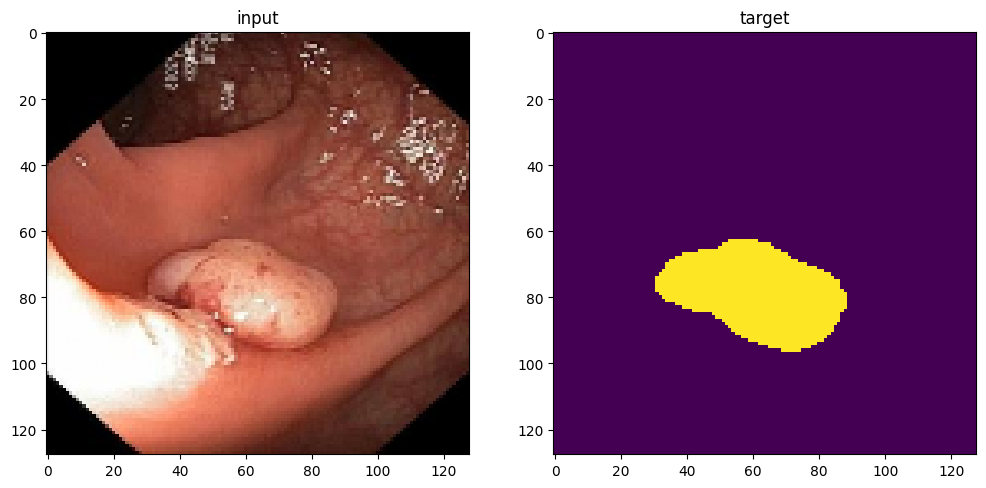

In [ ]:
# Example
check_all_ds = Dataset(data=val_files, transform=val_transforms)
check_all_loader = DataLoader(check_all_ds, batch_size=1)

check_data = first(check_all_loader)
image, label = (check_data["image"][0], check_data["label"][0])
image = image.permute(1, 2, 0).cpu().numpy()

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(image[:, :])
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(label[0][:, :])
plt.show()

## 2) Define Model & Set Hyper Parameter

In this notebook, we use the UNet model and DiceCELoss, which are built-in deep learning models and loss functions in MONAI. Because MONAI is a PyTorch-based framework, it is also compatible with pyTorch's optim.Adam.


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = UNet(spatial_dims=2, in_channels=3, out_channels=2,
             channels=(16, 32, 64, 128), strides=(2, 2, 2)).to(device)

learning_rate = 0.0001 # @param {type:"slider", min:1e-4, max:1e-3, step:1e-4}
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean")

max_epochs = 50  # @param {type:"slider", min:5, max:100, step:1}
val_interval = 2 # @param {type:"slider", min:1, max:10, step:1}

## 3) Train Model

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()

    epoch_loss = 0
    step = 0
    for i, batch_data in enumerate(train_loader):
        step += 1
        inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device))

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        if step % 10 == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                sw_batch_size = 1
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("UNet_best_metric_model.pth"), _use_new_zipfile_serialization=False) #####
                print("saved new best metric model")
            print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), os.path.join(f"UNet_{epoch + 1}_metric_model.pth"), _use_new_zipfile_serialization=False)
        np.save(os.path.join("UNet_epoch_loss"), np.array(epoch_loss_values))                                                    #####
        np.save(os.path.join("UNet_metric_values"), np.array(metric_values))

----------
epoch 1/50
epoch 1 average loss: 1.5983
----------
epoch 2/50
epoch 2 average loss: 1.5457
saved new best metric model
current epoch: 2 current mean dice: 0.1834
best mean dice: 0.1834 at epoch: 2
----------
epoch 3/50
epoch 3 average loss: 1.5028
----------
epoch 4/50
epoch 4 average loss: 1.4666
saved new best metric model
current epoch: 4 current mean dice: 0.2052
best mean dice: 0.2052 at epoch: 4
----------
epoch 5/50
epoch 5 average loss: 1.4303
----------
epoch 6/50
epoch 6 average loss: 1.4000
saved new best metric model
current epoch: 6 current mean dice: 0.2257
best mean dice: 0.2257 at epoch: 6
----------
epoch 7/50
epoch 7 average loss: 1.3751
----------
epoch 8/50
epoch 8 average loss: 1.3538
saved new best metric model
current epoch: 8 current mean dice: 0.2441
best mean dice: 0.2441 at epoch: 8
----------
epoch 9/50
epoch 9 average loss: 1.3338
----------
epoch 10/50
epoch 10 average loss: 1.3162
saved new best metric model
current epoch: 10 current mean dice:

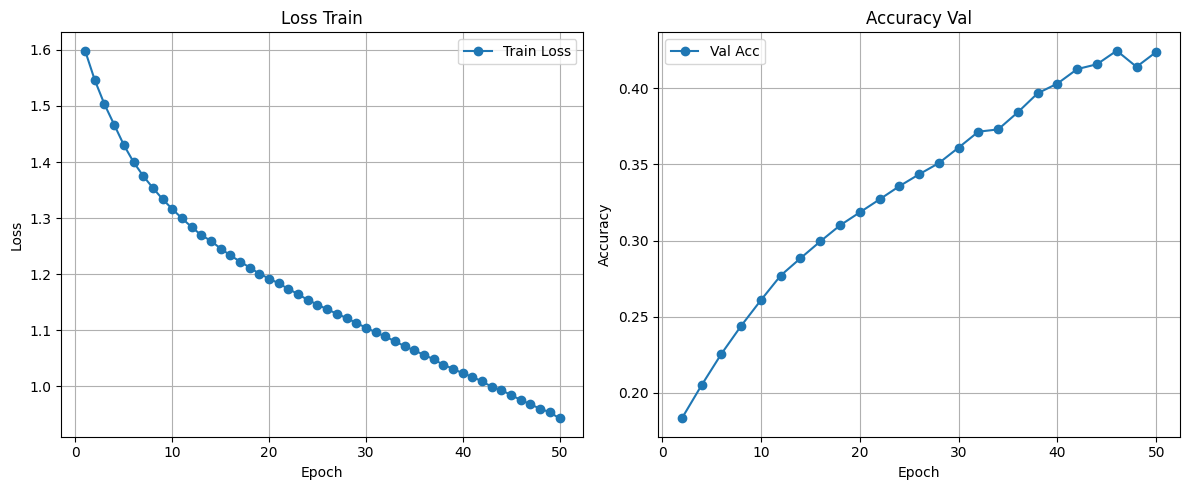

In [ ]:
# Plot grape
n_loss = range(1, len(epoch_loss_values) + 1)
n_acc = range(val_interval, val_interval * len(metric_values) + 1, val_interval)
plt.figure(figsize=(12, 5))

# 🔹 Loss
plt.subplot(1, 2, 1)
plt.plot(n_loss, epoch_loss_values, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Train')
plt.legend()
plt.grid(True)

# 🔹 Accuracy
plt.subplot(1, 2, 2)
plt.plot(n_acc, metric_values, marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Val')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 4) Inference & Evaluate & Save

In [ ]:
def visualize_rgb_with_dice(image, gt, pred, dice_value):
    """
    image: [3, H, W]
    gt:    [1, H, W]
    pred:  [1, H, W]
    dice_value: float
    """
    image = image.permute(1, 2, 0).cpu().numpy()
    gt = gt.squeeze().cpu().numpy()
    pred = pred.squeeze().cpu().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Input (RGB)")

    axes[1].imshow(image)
    axes[1].imshow(gt, alpha=0.4, cmap="Greens")
    axes[1].set_title("GT")

    axes[2].imshow(image)
    axes[2].imshow(pred, alpha=0.4, cmap="Reds")
    axes[2].set_title(f"Prediction\nDice = {dice_value:.4f}")

    axes[3].imshow(gt)
    axes[3].imshow(pred, alpha=0.4, cmap="Reds")
    axes[3].set_title(f"GT VS Prediction\nDice = {dice_value:.4f}")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# post_transforms is used to revert the output to its original size before test_transforms
test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=20)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=20)

post_transforms = Compose(
        [
            Invertd(
                keys="pred",
                transform=test_transforms,
                orig_keys="image",
                meta_keys="pred_meta_dict",
                orig_meta_keys="image_meta_dict",
                meta_key_postfix="meta_dict",
                nearest_interp=False,
                to_tensor=True,
            ),
            AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        ]
    )

Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 128.08it/s]


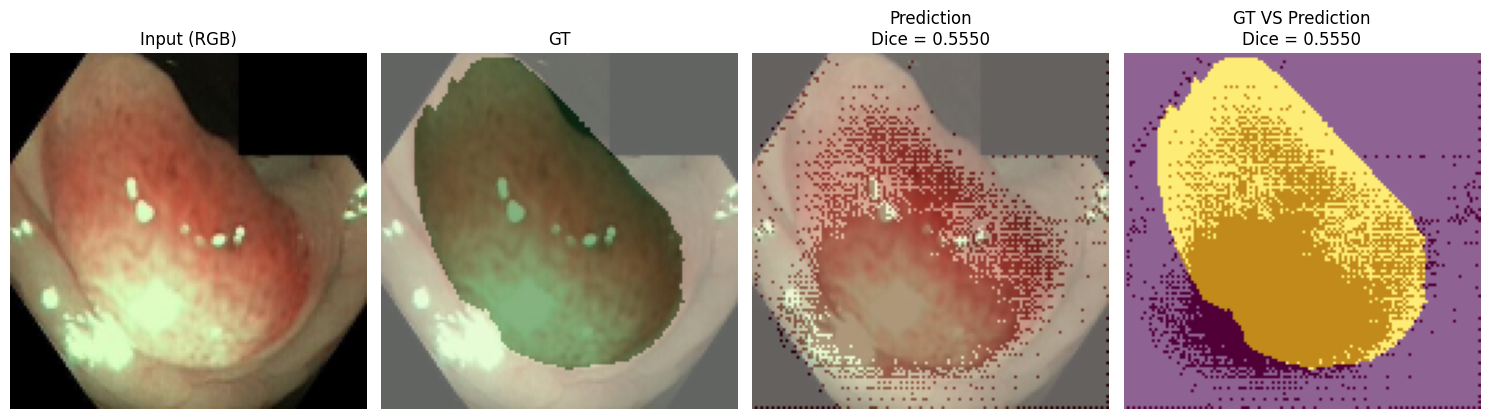

2025-12-29 21:03:58,795 INFO image_writer.py:197 - writing: output/UNet/cju2htabevq9108015qjei0x7_jpg.rf.33fa8a1405f44b065251cc7b3c457437/cju2htabevq9108015qjei0x7_jpg.rf.33fa8a1405f44b065251cc7b3c457437__UNet.png
NIfTI file saved in output/UNet


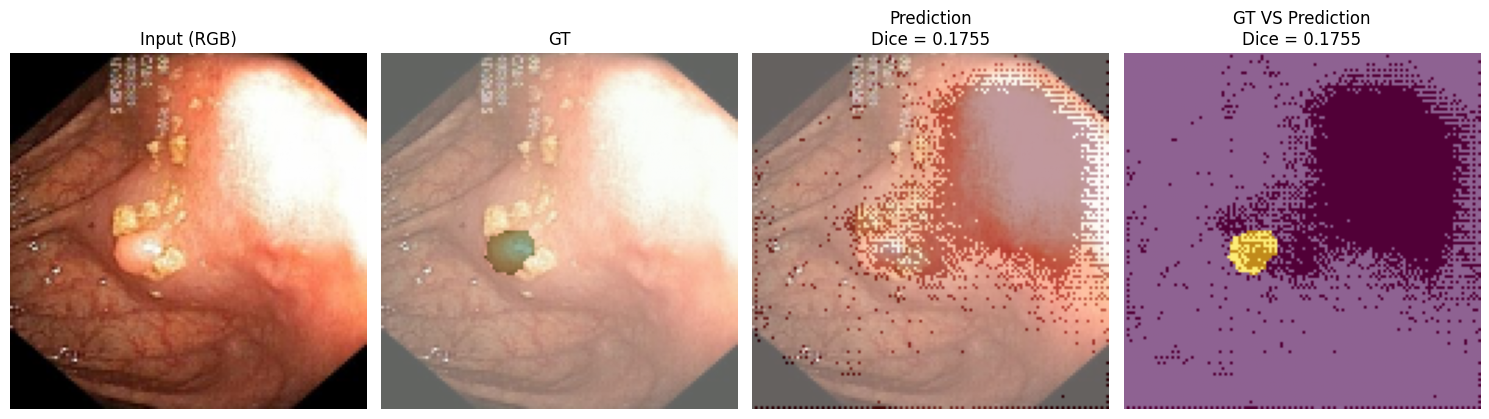

2025-12-29 21:04:00,220 INFO image_writer.py:197 - writing: output/UNet/cju2hugv9vget0799hhk7ksvg_jpg.rf.ac92e909e421430bbc7d98dbd2657c32/cju2hugv9vget0799hhk7ksvg_jpg.rf.ac92e909e421430bbc7d98dbd2657c32__UNet.png
NIfTI file saved in output/UNet

Mean Dice: 0.3652


In [ ]:
# Example & Save (.png)
model.load_state_dict(torch.load(os.path.join("/content/UNet_best_metric_model.pth")))
model.eval()

DSC_all = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        img = batch["image"].to(device)
        label = batch["label"].to(device)

        output = model(img)
        pred = torch.argmax(output, dim=1, keepdim=True)

        dice_metric = DiceMetric(include_background=False, reduction="mean")

        dice_metric(y_pred=pred[0], y=label[0].to(device))
        DSC_all.append(dice_metric.aggregate().item())

        if i % 1 == 0:
            visualize_rgb_with_dice(
                image=img[0],
                gt=label[0],
                pred=pred[0],
                dice_value=dice_metric.aggregate().item()
            )
        dice_metric.reset()

        batch["pred"] = pred
        batch = [post_transforms(i) for i in decollate_batch(batch)]

        # Create the output directory if it doesn't exist
        output_dir = "output/UNet"                                                                                                          #####
        os.makedirs(output_dir, exist_ok=True)

        # Create a tensor (e.g., a simple example tensor)
        tensor = torch.argmax(batch[0]["pred"], dim=0).detach().cpu()

        # Metadata for saving the NIfTI file
        metadata = {
                  "filename_or_obj": os.path.join(output_dir, "example.nii.gz")
                  }

        # Initialize the SaveImage transform
        saver = SaveImage(output_dir=output_dir, output_postfix="_UNet", output_ext=".png", resample=False)                                  #####

        # Save the tensor as a NIfTI file
        saver(tensor, meta_data=metadata)

        print(f"NIfTI file saved in {output_dir}")

print(f"\nMean Dice: {np.mean(DSC_all):.4f}")